In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from mtcnn.mtcnn import MTCNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from datetime import datetime
import logging

2024-02-25 20:28:48.511586: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-25 20:28:48.838751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 20:28:48.838970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 20:28:48.879486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 20:28:49.020474: I tensorflow/core/platform/cpu_feature_guar

POC for face extraction and dataset creation from the videos

In [2]:
def extract_frames(video_path, interval_seconds):
    capture = cv2.VideoCapture(video_path)
    frame_rate = capture.get(cv2.CAP_PROP_FPS)
    interval_frames = int(frame_rate * interval_seconds)

    frames = []
    frame_idx = 0
    while True:
        ret, frame = capture.read()
        if not ret:
            break
        if frame_idx % interval_frames == 0:
            frames.append(frame)
        frame_idx += 1

    capture.release()
    return frames

def extract_face(frame):
    detector = MTCNN()
    faces = detector.detect_faces(frame)
    if faces:
        x, y, w, h = faces[0]['box']
        face = frame[y:y + h, x:x + w]
        return cv2.resize(face, (224, 224))
    else:
        return None
    
def n_random_files(n, src_dir):
    files = list(map(lambda x: os.path.join(src_dir, x), os.listdir(src_dir)))
    sampled_files = random.sample(files, n)
    return sampled_files

def enablelog(log_folder):
    if not os.path.exists(log_folder):
        os.mkdir(log_folder)
    now = datetime.now()
    log_name = f"log-{now.strftime('%Y-%m-%d_%H:%M')}.log"
    log_file_path = os.path.join(log_folder, log_name)
    logging.basicConfig(level=logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s', handlers=[
        logging.FileHandler(log_file_path),
        logging.StreamHandler()
    ])

def close_log():
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
        handler.close()



In [3]:
dataset_folder = 'sample_dataset'
sequence_folder = 'sequence'

os.makedirs(sequence_folder, exist_ok=True)

In [12]:
def extract_faces_from_video(metadata,fake_per_real=4,convert_json=False,output_folder=sequence_folder,dataset_folder=dataset_folder,log_folder='logs/3dface'):
    
    enablelog(log_folder)
    
    if convert_json:
        metadata = pd.read_json(metadata).transpose()
        metadata.reset_index(level=0, inplace=True)
        metadata.rename(columns={'index':'filename'}, inplace=True)
    else:
        metadata = pd.read_csv(metadata)
    
    metadata = metadata.sample(frac=1).reset_index(drop=True)

    real_count = metadata['label'].value_counts()['REAL']
    logging.info(f"Real count: {real_count}")
    fake_count = real_count*fake_per_real
    logging.info(f"Fake count: {fake_count}")

    #select random fake_count number of fake videos
    fake_videos = metadata[metadata['label']=='FAKE']
    fake_videos = fake_videos.sample(fake_count)

    real_videos = metadata[metadata['label']=='REAL']

    new_metadata = pd.concat([fake_videos,real_videos])
    new_metadata = new_metadata.sample(frac=1).reset_index(drop=True)

    for idx,row in new_metadata.iterrows():
        filename = row['filename']
        video_path = os.path.join(dataset_folder, row['filename'])
        label = row['label']
        frames = extract_frames(video_path, 1)
        faces=[]
        for frame in frames:
            if len(frames) - ((i+1)*5) < 5:
                logging.info(f"Less than 5 frames left in {filename} {i}")
                break
            i=0
            face = extract_face(frame)
            if face is not None:
                faces.append(face)

            if len(faces) == 5:
                output_folder = os.path.join(sequence_folder, label)
                os.makedirs(output_folder, exist_ok=True)

                output_path = os.path.join(output_folder, f'{filename}{i}.npy')
                np.save(output_path, faces)
                logging.info(f"Saved {output_path}")
                faces =[]
                i+=1
    
    close_log()

In [ ]:
extract_faces_from_video('sample_dataset/metadata.csv',fake_per_real=1)

In [14]:
#load one npy file
data = np.load('sequence/REAL/wfzjxzhdkj.mp40.npy')
print(data.shape)

(5, 224, 224, 3)


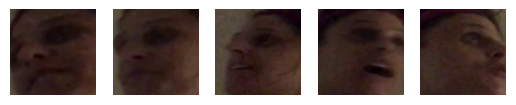

In [19]:
def view_img_from_npy(npy_file):
    data = np.load(npy_file)
    for i in range(5):
        plt.subplot(1,5,i+1)
        data[i] = cv2.cvtColor(data[i], cv2.COLOR_BGR2RGB)
        plt.imshow(data[i])
        plt.axis('off') 
    
    plt.show()

view_img_from_npy('sequence/REAL/wfzjxzhdkj.mp40.npy')

Actual Code for face extraction and dataset creation from the videos

In [ ]:
dataset_folder = "dfdc_train_part_00"
metadata = "dfdc_train_part_00/metadata.json"
sequence_folder = "sequence"

extract_faces_from_video(metadata, fake_per_real=4, convert_json=True, output_folder=sequence_folder, dataset_folder=dataset_folder, log_folder='logs/3d_data_creation')